In [1]:
import numpy
import apogee_tools as ap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy

In [2]:
ap_dict = ap.returnAspcapTable(['2M01195227+8409327'], params=['TEFF', 'LOGG', 'M_H', 'SNR'], save=False)

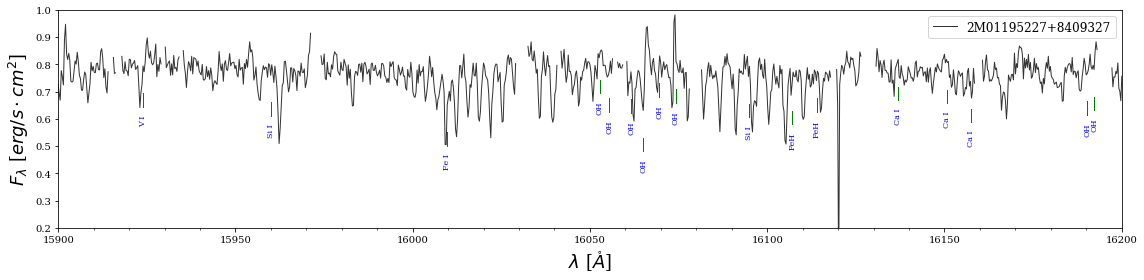

In [3]:
data = ap.Spectrum(id='2M01195227+8409327', type='ap1d', visit=1)
# data.plot(items=['spec', 'noise'], yrange=[0, 2e-13], xrange=[15900,16200])
data.mask(sigma=[.9,-0.05], pixel_buffer=[0,1])
data.flux = data.flux/max(data.flux)
data.plot(items=['spec', 'noise', 'lines'], yrange=[.2, 1], xrange=[15900,16200])

In [4]:
ap_id, plates, mjds, fibers = ap.searchVisits(id_name='2M01195227+8409327')
fibers

array([124, 130, 124, 129, 124, 130, 130, 130, 130], dtype=int16)

2M01195227+8409327 Parameters:
* SPT = M5 (Rajpurohit 2017)
* Teff = 3100 +/- 100 (Rajpurohit 2017)
* logg = 5.5 +/- 0.3 (Rajpurohit 2017)
* Fe/H = -0.3 +/- 0.06 (Rajpurohit 2017)
* vsini = 5.8 +/- 0.90 (Desphande 2013)
* rv = -41.01 +/- 0.09 (Desphande 2013)

Downsampled telluric spectrum resolution to model resolution.


/Users/admin/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:176: RuntimeWarning: invalid value encountered in less
  out[out<0.]= 0.
/Users/admin/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:177: RuntimeWarning: invalid value encountered in true_divide
  out/= numpy.tile(numpy.sum(out,axis=1),(len(x),1)).T


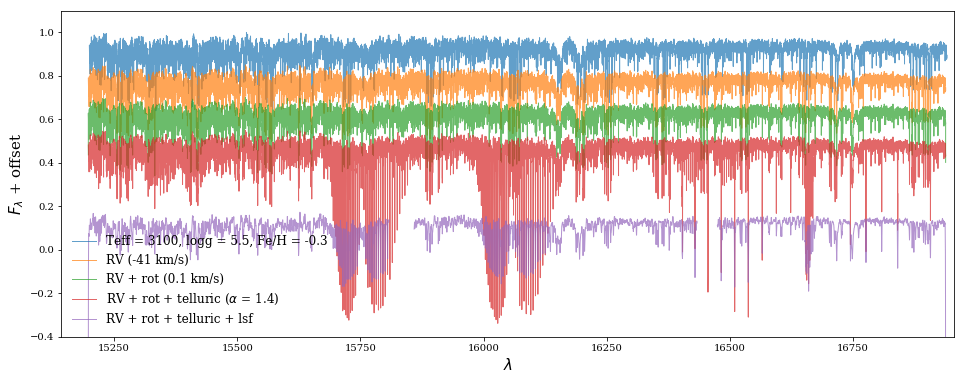

In [202]:
params = {'teff': 3100, 'logg': 5.5, 'z': -0.3, 'vsini': 0.1, 'rv': -41, 'alpha': 1.4}
synth = ap.makeModel(params=params, fiber=124, xrange=[data.wave[0],data.wave[-1]], res='300k', plot=True)

(nan, <apogee_tools.core.Spectrum object at 0x181cc33a90>, <apogee_tools.core.Spectrum object at 0x181e41cbe0>)


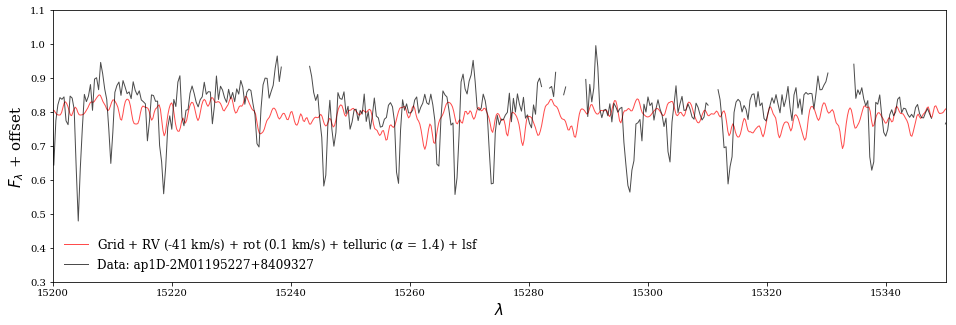

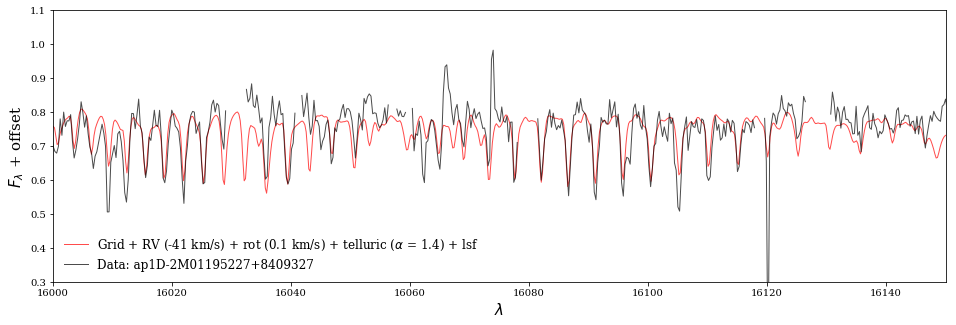

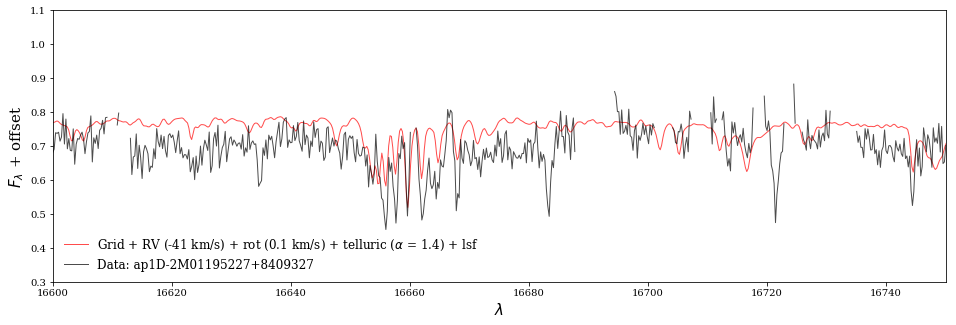

In [203]:
cont_mdl = continuum(data, synth, deg=1)
# scale = calcScale(data, cont_mdl)
print(ap.compareSpectra(data, synth))

bands = [[15200,15350], [16000,16150], [16600,16750]]

for band in bands:
    plt.figure(1, figsize=(16,5)) 
#     plt.plot(rv_sp.wave, rv_sp.flux, alpha=.7, linewidth=1, \
#              label=r'Grid: Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']))
    plt.plot(cont_mdl.wave, cont_mdl.flux+.05, alpha=.7, linewidth=1, color='r', \
             label=r'Grid + RV (%s km/s) + rot (%s km/s) + telluric ($\alpha$ = %s) + lsf'%(params['rv'], params['vsini'], params['alpha']))
    plt.plot(data.wave, data.flux,label='Data: ap1D-'+data.name, color='k', alpha=.7, linewidth=1)
    plt.xlim(band) #[15190,16950]
    plt.ylim(.3, 1.1)
    plt.legend(loc='lower left', frameon=False, fontsize=12)
    plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=15)
    plt.xlabel(r'$\lambda$', fontsize=15)
    plt.show()

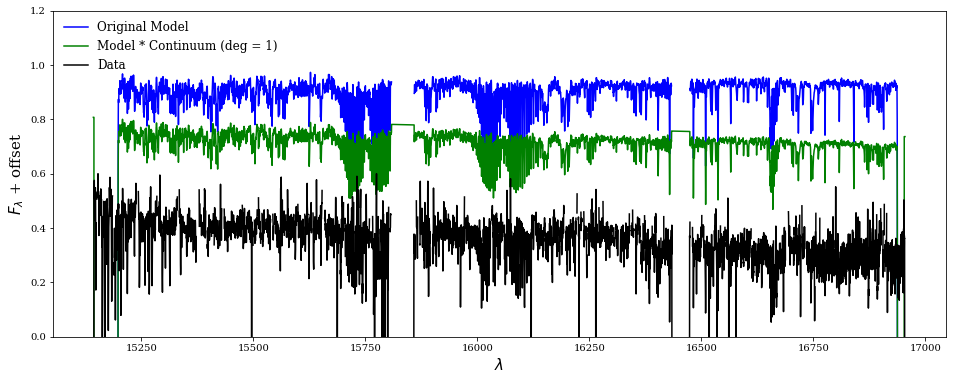

/Users/admin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/admin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/admin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/admin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RankWarning: Polyfit may be poorly conditioned


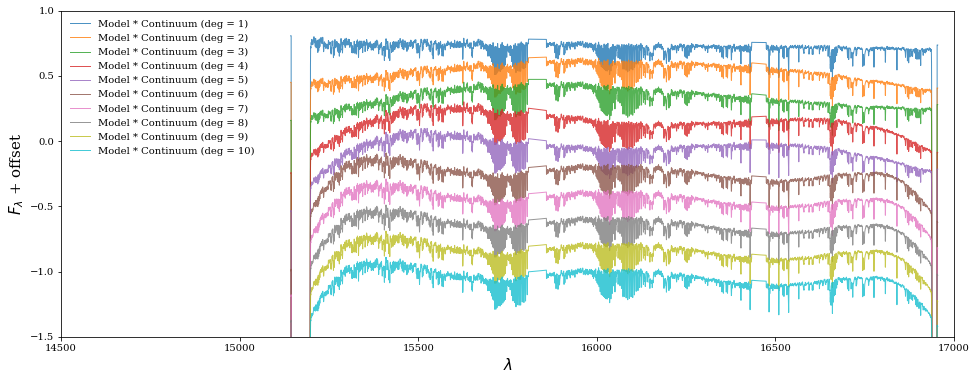

In [199]:
degree = 1
a = ap.continuum(data, synth, deg=degree)
plt.figure(1, figsize=(16,6)) 
plt.plot(synth.wave, synth.flux, color='b', label='Original Model')
plt.plot(a.wave, a.flux, color='g', label='Model * Continuum (deg = %s)'%(degree))
plt.plot(data.wave, data.flux-.4, color='k', label='Data')
plt.ylim(0, 1.2)
plt.legend(loc='upper left', frameon=False, fontsize=12)
plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=15)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.show()

plt.figure(1, figsize=(16,6)) 
for deg in range(10):
    degree = deg + 1
    a = continuum(data, synth, deg=degree)
    plt.plot(a.wave, a.flux-.2*deg, label='Model * Continuum (deg = %s)'%(degree), linewidth=1, alpha=.8)
plt.legend(loc='upper left', frameon=False, fontsize=10)
plt.ylim(-1.5, 1)
plt.xlim(14500, 17000)
plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=15)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.show()

In [115]:
params = {'teff': 3100, 'logg': 5.5, 'z': -0.3, 'vsini': 0.1, 'rv': -41, 'alpha': 1}

interp_sp = ap.interpolateGrid(labels=[params['teff'], params['logg'], params['z']], res='500k')
interp_sp.flux = interp_sp.flux/max(interp_sp.flux)
rv_sp   = ap.spec_tools.rvShiftSpec(interp_sp, rv=params['rv'])
rot_sp  = ap.applyVsini(rv_sp, vsini=params['vsini'])
tell_sp = ap.applyTelluric(rot_sp, alpha=params['alpha'])
lsf_sp  = ap.convolveLsf(tell_sp, fiber=124)

Downsampled telluric spectrum resolution to model resolution.


/Users/admin/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:176: RuntimeWarning: invalid value encountered in less
  out[out<0.]= 0.
/Users/admin/Desktop/astro_code/apogee_tools/apogee_tools/apogee_hack/spec/lsf.py:177: RuntimeWarning: invalid value encountered in true_divide
  out/= numpy.tile(numpy.sum(out,axis=1),(len(x),1)).T


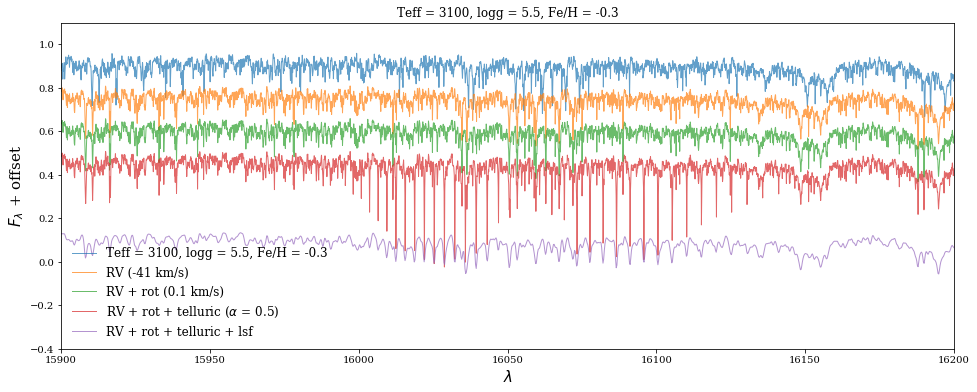

In [7]:
plt.figure(1, figsize=(16,6))  
plt.plot(interp_sp.wave, interp_sp.flux, alpha=.7, linewidth=1, label=r'Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']))
plt.plot(rv_sp.wave, rv_sp.flux-.15, label=r'RV (%s km/s)'%(params['rv']), alpha=.7, linewidth=1)
plt.plot(rot_sp.wave, rot_sp.flux-.3, label=r'RV + rot (%s km/s)'%(params['vsini']), alpha=.7, linewidth=1)
plt.plot(tell_sp.wave, tell_sp.flux-.45, label=r'RV + rot + telluric ($\alpha$ = %s)'%(params['alpha']), alpha=.7, linewidth=1)
plt.plot(lsf_sp.wave, lsf_sp.flux-.8, label=r'RV + rot + telluric + lsf', alpha=.7, linewidth=1)
plt.xlim([15900,16200]) #[15190,16950]
plt.ylim(-.4, 1.1)
plt.legend(loc='lower left', frameon=False, fontsize=12)
plt.ylabel(r'$F_{\lambda}$ + offset', fontsize=15)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.title('Teff = %s, logg = %s, Fe/H = %s'%(params['teff'], params['logg'], params['z']))
plt.show()